In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from utils import *
plt.style.use('ggplot')
%matplotlib inline

# Training Curves

Use this in a similar manner to tensorboard, to check that things are training.

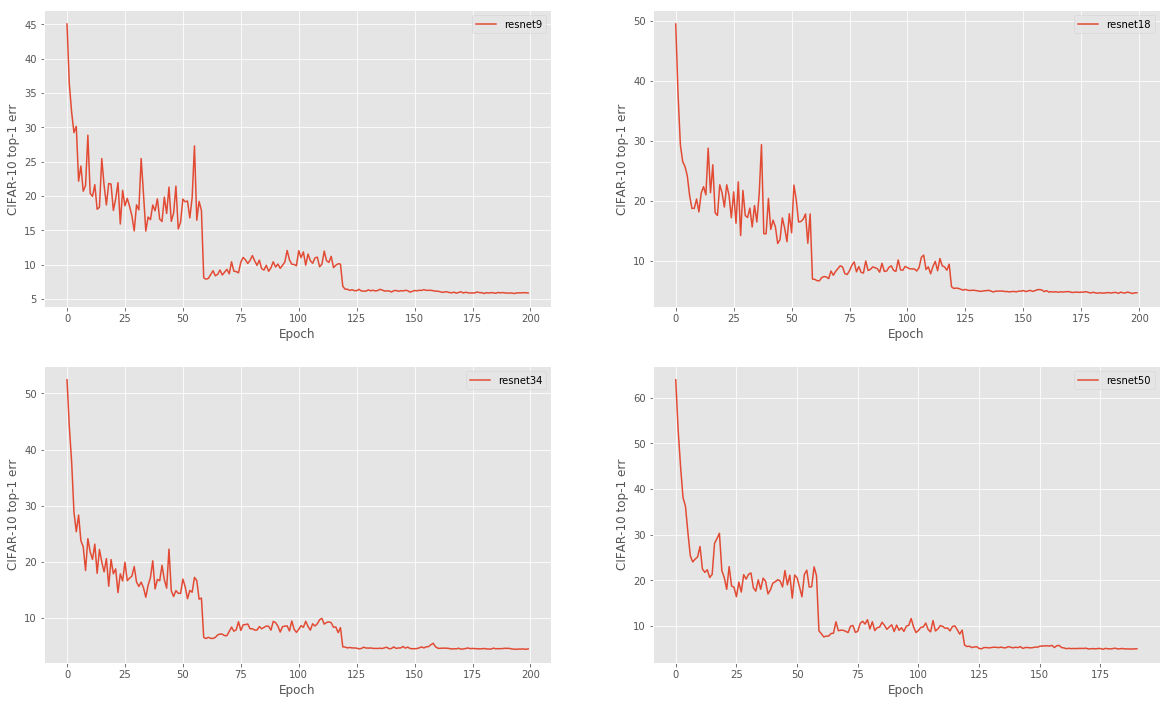

In [14]:
checkpoints = ['resnet9','resnet18','resnet34','resnet50'] # put your checkpoint files in here

cols = 2
rows = len(checkpoints) // cols

fig, axs = plt.subplots(rows,cols,figsize=(20, rows*6)) # width=20cm, height=6cm per row
axs = axs.ravel()

for checkpoint, ax in zip(checkpoints, axs):
    sd = torch.load('checkpoints/%s.t7' % checkpoint, map_location='cpu')
    ax.plot(list(range(len(sd['error_history']))), sd['error_history'])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('CIFAR-10 top-1 err')
    ax.legend([checkpoint])
    
plt.show()

Given a family of ResNets we can extract a Pareto curve of accuracy vs. number of parameters:

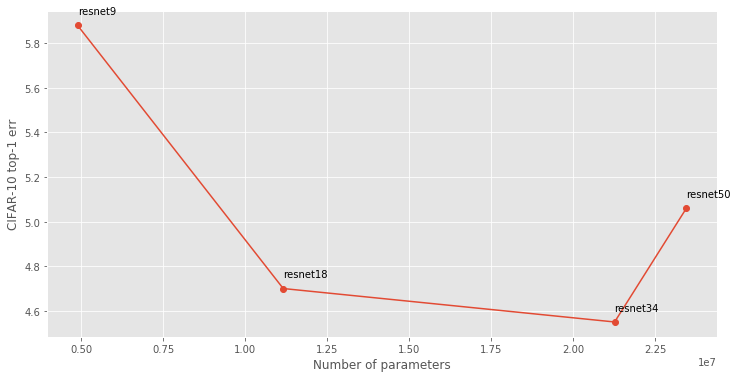

In [13]:
fig, ax = plt.subplots(figsize=(12,6))

x = []
y = []

for checkpoint in checkpoints:
    sd = torch.load('checkpoints/%s.t7' % checkpoint, map_location='cpu')
    
    x_  = get_no_params(sd['net'])
    y_  = sd['error_history'][-1]
    x.append(x_)
    y.append(y_)
    
for i, net in enumerate(checkpoints):
    offset = 0.05
    ax.annotate(net, (x[i]+offset, y[i]+offset))    

    
ax.set_xlabel('Number of parameters')
ax.set_ylabel('CIFAR-10 top-1 err')
ax.plot(x,y, marker='o')
plt.show()


You can see immediately that ResNet-50 is over-parameterised for a small task like CIFAR-10. One could employ some more training tricks, but for fairness I will just consider the "Pareto frontier" to be ResNet-9-18-34.

The idea proposed in Han et al. is that we can beat this Pareto frontier by keeping the network structure the same but removing individual weights.

# Pruning Curves

Check that the model is pruning correctly. 

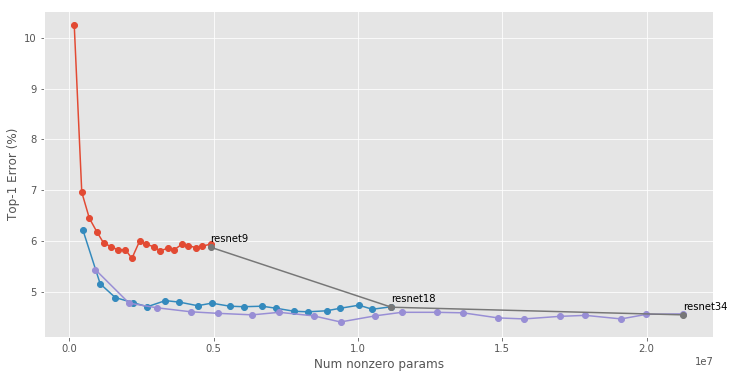

In [39]:
fig,ax      = plt.subplots(figsize=(12,6))
prune_rates = np.arange(0,100,step=5)
checkpoints = ['resnet9','resnet18','resnet34']

def get_nonzeros(sd):
    tot = 0
    for mask in sd['masks']:
        tot += torch.sum(mask!=0)
    return tot

for checkpoint in checkpoints:
    x = []
    y = []
    for prune_rate in prune_rates:
        sd = torch.load('checkpoints/%s.t7' % str(checkpoint + '_l1_' + str(prune_rate)), map_location='cpu')
        x.append(get_nonzeros(sd))
        y.append(sd['error_history'][-1])
    ax.plot(x,y,marker='o')

x = []
y = []

for checkpoint in checkpoints:
    sd = torch.load('checkpoints/%s.t7' % checkpoint, map_location='cpu')
    
    x_  = get_no_params(sd['net'])
    y_  = sd['error_history'][-1]
    x.append(x_)
    y.append(y_)
    
for i, net in enumerate(checkpoints):
    offset = 0.1
    ax.annotate(net, (x[i]+offset, y[i]+offset))    
ax.plot(x,y, marker='o')

ax.set_xlabel('Num nonzero params')
ax.set_ylabel('Top-1 Error (%)')
plt.show()